In [ ]:
from copy import deepcopy
import math
import functools 
import random
import pandas as pd
import time
import resource
import tracemalloc
from time import sleep
import networkx as nx
import matplotlib.pyplot as plt


The following class contains the maintained information for identifying the state of the board, and the fields needed for the search algorithms below.

In [ ]:
class TileState():
  board = list() # [['b',1,2,3],[4,5,6,7],[8,9,10,11],[12,13,14,15]] - contains the board state as 2D list representation. Each inner array represents a row.
  inverse_method = None # Pointer to the inverse method for the one which created the current instance.
  parent_state = None # For backtracking when the solution was found.
  h = 0 # The huristic function's value for the current state.
  g = 0 # The cost of the best path from the initial state to this instance.
  f = 0 # Stored value (maintained in the algorithms).
  F = 0 # Dynamic value (maintained in the algorithms).
  operators = list() # Available operators to apply when expanding this instance.
  operators_table=[] # Contains the osf function state. This list is a list of tuples, where each tuple is a pair of list of operators and the delta f. 
  C = False # Collapsed flag.

  # repr example for the complete state for the 15-puzzle.
  # |'b',1,2,3| every element is row
  # | 4 ,5,6,7|
  # | 8 ,9,10,11|
  # | 12 ,13,14,15|

  def __init__(self,board):
    self.board = board
    self.h = self.culc_huristics()
    self.f = self.g + self.h
    self.operators = [self.move_blank_down,self.move_blank_up,self.move_blank_right,self.move_blank_left]
    self.C = False

  def culc_huristics(self): # Computes the huristic value of the current board by Manhatan Distance.
    h = 0
    for row in range(len(self.board)):
      for col in range(len(self.board[0])):
        element = self.board[row][col]
        if isinstance(element,int):
          expected_row,expected_col = math.floor(element/len(self.board)),element%len(self.board[0])
        else:
          expected_row,expected_col = 0,0
        manhatan_dist = abs(expected_row - row) + abs(expected_col - col)
        h += manhatan_dist

    return h


  def osf(self): # Returns the next operators to apply for the enhanced search algotihmns and the next delta F as tuple (see operators_table doc)
    return (list(),None) if len(self.operators_table) == 0 else self.operators_table.pop(0)


  # Called when a state is generated (on moves methods). It looks in the current state and the available operators and calculates delta_f for each available state from the current one.
  def build_osf(self):
    delta_f_by_operator_list = list()
    current_h = self.culc_huristics()
    blank_row, blank_col = self.get_blank_loc()

    if blank_row == 0: # we can move down for sure.
      #down (other number will move up)
      other_card_number = self.board[blank_row + 1][blank_col]
      expected_other_card_row, expected_other_card_col = math.floor(other_card_number/len(self.board)),other_card_number%len(self.board[0])
      huristics_change_of_selected_card = -1 if expected_other_card_row > blank_row + 1 else 1
      delta_h = 1 + huristics_change_of_selected_card # since we move blank from the row it should be.
      delta_f = delta_h + 2 # since 2 is delta g
      delta_f_by_operator = (self.move_blank_down , delta_f)
      delta_f_by_operator_list.append(delta_f_by_operator)
    
      if not blank_col == 0: # we can move left for sure (other number to right)
        other_card_number = self.board[blank_row][blank_col - 1]
        expected_other_card_row, expected_other_card_col = math.floor(other_card_number/len(self.board)),other_card_number%len(self.board[0])
        huristics_change_of_selected_card = -1 if expected_other_card_col > blank_col - 1 else 1
        delta_h = -1 + huristics_change_of_selected_card
        delta_f = delta_h + 2 # since 2 is delta g
        delta_f_by_operator = (self.move_blank_left , delta_f)
        delta_f_by_operator_list.append(delta_f_by_operator)

      if not blank_col == len(self.board) - 1: # we can move the blank to the right (and the selected card to the left)
        other_card_number = self.board[blank_row][blank_col + 1]
        expected_other_card_row, expected_other_card_col = math.floor(other_card_number/len(self.board)),other_card_number%len(self.board[0])
        huristics_change_of_selected_card = -1 if expected_other_card_col < blank_col + 1 else 1
        delta_h = 1 + huristics_change_of_selected_card
        delta_f = delta_h + 2 # since 2 is delta g
        delta_f_by_operator = (self.move_blank_right , delta_f)
        delta_f_by_operator_list.append(delta_f_by_operator)

    elif blank_row == len(self.board) - 1:
      # up (and move the other card down)
      other_card_number = self.board[blank_row - 1][blank_col]
      expected_other_card_row, expected_other_card_col = math.floor(other_card_number/len(self.board)),other_card_number%len(self.board[0])
      huristics_change_of_selected_card = -1 if expected_other_card_row > blank_row - 1 else 1
      delta_h = 1 + huristics_change_of_selected_card
      delta_f = delta_h + 2 # since 2 is delta g
      delta_f_by_operator = (self.move_blank_up , delta_f)
      delta_f_by_operator_list.append(delta_f_by_operator)


      if not blank_col == 0: # we can move left for sure (other number to right)
        other_card_number = self.board[blank_row][blank_col - 1]
        expected_other_card_row, expected_other_card_col = math.floor(other_card_number/len(self.board)),other_card_number%len(self.board[0])
        huristics_change_of_selected_card = -1 if expected_other_card_col > blank_col - 1 else 1
        delta_h = -1 + huristics_change_of_selected_card
        delta_f = delta_h + 2 # since 2 is delta g
        delta_f_by_operator = (self.move_blank_left , delta_f)
        delta_f_by_operator_list.append(delta_f_by_operator)

      if not blank_col == len(self.board) - 1: # we can move the blank to the right (and the selected card to the left)
        other_card_number = self.board[blank_row][blank_col + 1]
        expected_other_card_row, expected_other_card_col = math.floor(other_card_number/len(self.board)),other_card_number%len(self.board[0])
        huristics_change_of_selected_card = -1 if expected_other_card_col < blank_col + 1 else 1
        delta_h = 1 + huristics_change_of_selected_card
        delta_f = delta_h + 2 # since 2 is delta g
        delta_f_by_operator = (self.move_blank_right , delta_f)
        delta_f_by_operator_list.append(delta_f_by_operator)

    else:
      #down (other number will move up)
      other_card_number = self.board[blank_row + 1][blank_col]
      expected_other_card_row, expected_other_card_col = math.floor(other_card_number/len(self.board)),other_card_number%len(self.board[0])
      huristics_change_of_selected_card = -1 if expected_other_card_row > blank_row + 1 else 1
      delta_h = 1 + huristics_change_of_selected_card # since we move blank from the row it should be.
      delta_f = delta_h + 2 # since 2 is delta g
      delta_f_by_operator = (self.move_blank_down , delta_f)
      delta_f_by_operator_list.append(delta_f_by_operator)

      # up (and move the other card down)
      other_card_number = self.board[blank_row - 1][blank_col]
      expected_other_card_row, expected_other_card_col = math.floor(other_card_number/len(self.board)),other_card_number%len(self.board[0])
      huristics_change_of_selected_card = -1 if expected_other_card_row > blank_row - 1 else 1
      delta_h = 1 + huristics_change_of_selected_card
      delta_f = delta_h + 2 # since 2 is delta g
      delta_f_by_operator = (self.move_blank_up , delta_f)
      delta_f_by_operator_list.append(delta_f_by_operator)

      if not blank_col == 0: # we can move left for sure (other number to right)
        other_card_number = self.board[blank_row][blank_col - 1]
        expected_other_card_row, expected_other_card_col = math.floor(other_card_number/len(self.board)),other_card_number%len(self.board[0])
        huristics_change_of_selected_card = -1 if expected_other_card_col > blank_col - 1 else 1
        delta_h = -1 + huristics_change_of_selected_card
        delta_f = delta_h + 2 # since 2 is delta g
        delta_f_by_operator = (self.move_blank_left , delta_f)
        delta_f_by_operator_list.append(delta_f_by_operator)

      if not blank_col == len(self.board) - 1: # we can move the blank to the right (and the selected card to the left)
        other_card_number = self.board[blank_row][blank_col + 1]
        expected_other_card_row, expected_other_card_col = math.floor(other_card_number/len(self.board)),other_card_number%len(self.board[0])
        huristics_change_of_selected_card = -1 if expected_other_card_col < blank_col + 1 else 1
        delta_h = 1 + huristics_change_of_selected_card
        delta_f = delta_h + 2 # since 2 is delta g
        delta_f_by_operator = (self.move_blank_right , delta_f)
        delta_f_by_operator_list.append(delta_f_by_operator)


    delta_f_by_operator_list.sort(key=lambda delta_f_by_operator: delta_f_by_operator[1])
    delta_fs_from_current_state = list(set(map(lambda x:x[1], delta_f_by_operator_list)))
    delta_fs_from_current_state.sort()

    # operators tables sorted from the best operators to the worst ones.

    grouped_operators_by_delta_f = [[y[0] for y in delta_f_by_operator_list if y[1]==x] for x in delta_fs_from_current_state]
    delta_f = list()
    for i in range(len(delta_fs_from_current_state) - 1):
      delta_f.append(delta_fs_from_current_state[i+1] - delta_fs_from_current_state[i])
    delta_f.append(None)
    operators_table = list()
    for i in range(len(delta_f)):
      operators_table.append((grouped_operators_by_delta_f[i],delta_f[i]))
    self.operators_table = operators_table


  def get_blank_loc(self):
    for i in range(len(self.board)):
      if 'b' in self.board[i]:
        return i,self.board[i].index('b')

  def move_blank_down(self):
    blank_loc = self.get_blank_loc()
    if blank_loc[0] == len(self.board) - 1:
      return None

    new_state = deepcopy(self)
    new_state.inverse_method = new_state.move_blank_up
    new_state.operators = [new_state.move_blank_down,new_state.move_blank_up,new_state.move_blank_right,new_state.move_blank_left]
    new_state.operators.remove(new_state.inverse_method)
    new_state.parent = self
    new_state.build_osf()

    new_state.board[blank_loc[0]][blank_loc[1]] = new_state.board[blank_loc[0] + 1][blank_loc[1]]
    new_state.board[blank_loc[0] + 1][blank_loc[1]] = 'b'

    new_state.h = new_state.culc_huristics()
    new_state.f = new_state.g + new_state.h
    new_state.C = False

    return new_state

  def move_blank_up(self):
    blank_loc = self.get_blank_loc()
    if blank_loc[0] == 0:
      return None

    new_state = deepcopy(self)
    new_state.inverse_method = new_state.move_blank_down
    new_state.operators = [new_state.move_blank_down,new_state.move_blank_up,new_state.move_blank_right,new_state.move_blank_left]
    new_state.operators.remove(new_state.inverse_method)
    new_state.parent = self
    new_state.build_osf()
    new_state.board[blank_loc[0]][blank_loc[1]] = new_state.board[blank_loc[0] - 1][blank_loc[1]]
    new_state.board[blank_loc[0] - 1][blank_loc[1]] = 'b'

    new_state.h = new_state.culc_huristics()
    new_state.f = new_state.g + new_state.h
    new_state.C = False

    return new_state


  def move_blank_right(self):
    blank_loc = self.get_blank_loc()
    if blank_loc[1] == len(self.board[0]) -1:
      return None

    new_state = deepcopy(self)
    new_state.inverse_method = new_state.move_blank_left
    new_state.operators = [new_state.move_blank_down,new_state.move_blank_up,new_state.move_blank_right,new_state.move_blank_left]
    new_state.operators.remove(new_state.inverse_method)
    new_state.parent = self
    new_state.build_osf()
    new_state.board[blank_loc[0]][blank_loc[1]] = new_state.board[blank_loc[0]][blank_loc[1] + 1]
    new_state.board[blank_loc[0]][blank_loc[1] + 1] = 'b'

    new_state.h = new_state.culc_huristics()
    new_state.f = new_state.g + new_state.h
    new_state.C = False

    return new_state


  def move_blank_left(self):
    blank_loc = self.get_blank_loc()
    if blank_loc[1] == 0:
      return None

    new_state = deepcopy(self)
    new_state.inverse_method = new_state.move_blank_right
    new_state.operators = [new_state.move_blank_down,new_state.move_blank_up,new_state.move_blank_right,new_state.move_blank_left]
    new_state.operators.remove(new_state.inverse_method)
    new_state.parent = self
    new_state.build_osf()

    new_state.board[blank_loc[0]][blank_loc[1]] = new_state.board[blank_loc[0]][blank_loc[1] - 1]
    new_state.board[blank_loc[0]][blank_loc[1] - 1] = 'b'

    new_state.h = new_state.culc_huristics()
    new_state.f = new_state.g + new_state.h
    new_state.C = False

    return new_state


  def board_state(self):
    output = ''
    for i in range(len(self.board)):
      row = '| '
      for j in range(len(self.board[i])):
        row = row + str(self.board[i][j]) + ' '
      
      output = output + row + '|\n' 

    return output + '\n \n'

  def __repr__(self):
    
    output = ''
    for i in range(len(self.board)):
      row = '| '
      for j in range(len(self.board[i])):
        row = row + str(self.board[i][j]) + ' '
      
      output = output + row + '|\n' 

    return output + '\n \n' 

  def __eq__(self,other):
    if isinstance(other, TileState):
        return self.board == other.board
    return False



In [ ]:
# This cell contains utils for execution of the search algorithms in the cells below.

def main_backtracking(state):
  res = backtracking(state)
  return res[::-1]

# build the path from the solution back to the initial state
def backtracking(state):
  if state.parent_state is None:
    return [state]
  returned_array = [state] + backtracking(state.parent)
  return returned_array

# returns the instance with the same board state.
# Assumption: The instance exists exactly in one of the lists (open or closed)
def get_existing_child(child,open,closed):
  if child in open:
    return open[open.index(child)]
  else:
    return closed[closed.index(child)]


# This function is called from the benchmark function. This function creates an initial instance to run the search algorithms on.
# When calling to this function, call it with the solution state (when the blank and the numbers are in their positions)
# This function creates the initial state from defined number of 'steps' from the 'complete_state'
def make_an_initial_state(complete_state, steps = 10):
  if steps == 0:
    # make all operators available when running the algorithm, especialliy the operator for the optimal path.
    complete_state.operators = [complete_state.move_blank_down,complete_state.move_blank_up,complete_state.move_blank_right,complete_state.move_blank_left] 
    return complete_state
  random.shuffle(complete_state.operators) # randomize the selection of the next step. Each state keeps the inverse operation for the one created them so the inverse function can not be chosen.
  for operator in complete_state.operators:
    new_state = operator()
    if new_state is None: # illegal move
      continue
    return make_an_initial_state(new_state,steps-1) # the next step was selected.


# Collapse shrinks the tree rooted in 'state_node' and contains only the children that are in 'children_to_collapse'.
# The funcion also updates the F value of 'state_node' to be the minimum of the f-value of the frontier nodes.
def collapse(state_node,children_to_collapse,open,closed):
  frontier_f_values = [float('inf')]
  childs_f = []
  for child_state_node in children_to_collapse:
    min_subtree_frontier_f_value = rec_collapse(child_state_node,open,closed)
    frontier_f_values.append(min_subtree_frontier_f_value)
    childs_f.append(child_state_node.f)
  min_frontier_f_value = min(frontier_f_values)
  if not min_frontier_f_value == float('inf'): # there was a child that was removed
    state_node.F = min_frontier_f_value
  else:
    state_node.F = min(childs_f)


  state_node.C = True


def rec_collapse(state_node,open,closed):
  if state_node in open: # this node is a frontier node.
    open.remove(state_node)
    return state_node.f
  if state_node in closed: # the node is an internal node.
    frontier_f_values = [float('inf')]
    closed.remove(state_node)
    for operator in state_node.operators:
      child_state_node = state_node.operator()
      if child_state_node is None:
        continue
      min_subtree_frontier_f_value = rec_collapse(child_state_node,open,closed)
      frontier_f_values.append(min_subtree_frontier_f_value)
    return min(frontier_f_values)
  return float('inf') # this node wasn't in the subtree when calling to collapse.


# restores the subtree rooted in node.
# Assumption: the f function is non monotonically decreasing.
def restore(node,open,closed,F_root):
  for operator in node.operators:
    child_state = operator() #generate with some h

    if child_state is None: # child is illegal
      continue

    g_new = node.g + 2 # 2 - the cost of swaping between the blank and the number.

    if child_state in open or child_state in closed: # we generated this child before and we are examing if we found a better path when restoring the subtree of root.
      existing_child = get_existing_child(child_state,open,closed)
      if existing_child.g <= g_new:
          continue
      existing_child.g = g_new
      existing_child.parent_state = node
      if existing_child in closed:
        for existing_child_operator in existing_child.operators:
          child_of_existing = existing_child_operator() # generate the same grandchildren with the better path.
          restore(child_of_existing,open,closed,F_root)
      
    else: # the simple case - we just generate a child which is not existing right now.
      child_state.g = g_new
      child_state.f = child_state.g + child_state.h
      child_state.parent_state = node
      if child_state.f >= F_root: # we arrived to the frontier of the root's subtree.
        open.append(child_state)
      else: # we need to expand the generated child.
        closed.append(child_state)
        restore(child_state,open,closed,F_root)


In [ ]:
def a_star_late(state,goal_test= lambda state: state.h == 0):
  state.g = 0
  open = list()
  open.append(state)
  closed = list()
  perfomance = dict()
  
  # for final results
  perfomance['generated'] = 0
  perfomance['expanded'] = 0
  perfomance['max open length'] = 0
  perfomance['max closed length'] = 0
  perfomance['regenerations'] = 0

  while(len(open) > 0):
    best = open.pop(0)

    if goal_test(best):
      return perfomance,main_backtracking(best)

    closed.append(best)
    perfomance['expanded'] += 1
    for operator in best.operators:
      new_child_state = operator() #generate

      if new_child_state is None: # move is illegal
        continue

      if not new_child_state in closed or new_child_state in open:
        perfomance['generated'] += 1

      g_new = best.g + 2 #move blank and the other card.
      if new_child_state in closed or new_child_state in open:
        perfomance['regenerations'] += 1
        existing_child = get_existing_child(new_child_state,open,closed)
        if existing_child.g <= g_new:
          continue
        if existing_child in closed:
          closed.remove(existing_child)
        if existing_child in open:
          open.remove(existing_child)

      new_child_state.g = g_new
      new_child_state.f = new_child_state.g + new_child_state.h
      new_child_state.parent_state = best

      open.append(new_child_state)
      

    perfomance['max open length'] = perfomance['max open length'] if len(open) <= perfomance['max open length'] else len(open)
    perfomance['max closed length'] = perfomance['max closed length'] if len(closed) <= perfomance['max closed length'] else len(closed)
    
    open.sort(key=lambda state: (state.f,state.h))
  
  return "no path was found to the solution"



In [ ]:
def a_star_early(state,goal_test= lambda state: state.h == 0):
  state.g = 0
  U = float('inf')
  open = list()
  open.append(state)
  closed = list()
  perfomance = dict()
  
  # for final results
  perfomance['generated'] = 0
  perfomance['expanded'] = 0
  perfomance['max open length'] = 0
  perfomance['max closed length'] = 0
  perfomance['regenerations'] = 0
  solution_state = None

  while(len(open) > 0 and open[0].f < U):
    best = open.pop(0)
    closed.append(best)
    perfomance['expanded'] += 1

    for operator in best.operators:
      new_child_state = operator() #generate

      if new_child_state is None: #move is illegal
        continue

      if not new_child_state in closed or new_child_state in open:
        perfomance['generated'] += 1

      g_new = best.g + 2 #move blank and the other card.
      if new_child_state in closed or new_child_state in open:
        perfomance['regenerations'] += 1
        existing_child = get_existing_child(new_child_state,open,closed)
        if existing_child.g <= g_new:
          continue
        if existing_child in closed:
          closed.remove(existing_child)
        if existing_child in open:
          open.remove(existing_child)

      if goal_test(new_child_state):
        if g_new < U:
          solution_state = new_child_state
          U = g_new
          open = [state for state in open if state.f < U]

      new_child_state.g = g_new
      new_child_state.f = new_child_state.g + new_child_state.h
      new_child_state.parent_state = best

      if new_child_state.f < U:
        open.append(new_child_state)
      

    perfomance['max open length'] = perfomance['max open length'] if len(open) <= perfomance['max open length'] else len(open)
    perfomance['max closed length'] = perfomance['max closed length'] if len(closed) <= perfomance['max closed length'] else len(closed)
    
    open.sort(key=lambda state: (state.f,state.h))
  
  return "no path was found to the solution" if U == float('inf') else perfomance,main_backtracking(solution_state)



In [ ]:
def partial_expansion_a_star(state,goal_test= lambda state: state.h == 0):
  state.g = 0
  state.F = state.h # State.F by default is state.f = state.g + state.h. state.g = 0 => state.F = state.f = state.h
  open = list()
  open.append(state)
  closed = list()
  perfomance = dict()

  # for final results
  perfomance['generated'] = 0
  perfomance['expanded'] = 0
  perfomance['max open length'] = 0
  perfomance['max closed length'] = 0
  perfomance['regenerations'] = 0

  while(len(open) > 0):
    best = open.pop(0)

    if goal_test(best):
      return perfomance,main_backtracking(best)

    exceeding_children = list()
    perfomance['expanded'] += 1

    if best.C:
      restore(best,open,closed,best.F)
      best.C = False

    for operator in best.operators:
      new_child_state = operator() # generate
      
      if new_child_state is None: # move is illegal
        continue

      if not new_child_state in closed or new_child_state in open:
        perfomance['generated'] += 1

      g_new = best.g + 2 #move blank and the other card.
      if new_child_state in closed or new_child_state in open:
        perfomance['regenerations'] += 1
        existing_child = get_existing_child(new_child_state,open,closed)
        if existing_child.g <= g_new:
          continue
        if existing_child in closed:
          closed.remove(existing_child)
        if existing_child in open:
          open.remove(existing_child)

        new_child_state.C = existing_child.C
        new_child_state.F = existing_child.F

      new_child_state.g = g_new
      new_child_state.f = new_child_state.g + new_child_state.h

      if new_child_state.C == False:
        new_child_state.F = new_child_state.f

      new_child_state.parent_state = best

      if new_child_state.f == best.F:
        open.append(new_child_state)
      elif best.F < new_child_state.f:
        exceeding_children.append(new_child_state)

    if not len(exceeding_children) == 0 and best.f == best.F:
      collapse(best,exceeding_children,open,closed) 
      open.append(best)
    else:
      closed.append(best)

    perfomance['max open length'] = perfomance['max open length'] if len(open) <= perfomance['max open length'] else len(open)
    perfomance['max closed length'] = perfomance['max closed length'] if len(closed) <= perfomance['max closed length'] else len(closed)
    open.sort(key=lambda state: (state.F,state.h))
  
  return "no path was found to the solution"


In [ ]:
def partial_expansion_a_star_early(state,goal_test= lambda state: state.h == 0):
  state.g = 0
  U = float('inf')
  state.F = state.h # State.F by default is state.f = state.g + state.h. state.g = 0 => state.F = state.f = state.h
  open = list()
  open.append(state)
  closed = list()
  perfomance = dict()
  # for final results
  perfomance['generated'] = 0
  perfomance['expanded'] = 0
  perfomance['max open length'] = 0
  perfomance['max closed length'] = 0
  perfomance['regenerations'] = 0
  
  solution_state = None
  while(len(open) > 0 and open[0].f < U):
    best = open.pop(0)

    
    exceeding_children = list()
    perfomance['expanded'] += 1
    if best.C:
      restore(best,open,closed,best.F)
      best.C = False

    for operator in best.operators:
      new_child_state = operator() # generate
      
      if new_child_state is None: # move is illegal
        continue
      if not new_child_state in closed or new_child_state in open:
        perfomance['generated'] += 1

      g_new = best.g + 2 #move blank and the other card.
      if new_child_state in closed or new_child_state in open:
        perfomance['regenerations'] += 1
        existing_child = get_existing_child(new_child_state,open,closed)
        if existing_child.g <= g_new:
          continue
        if existing_child in closed:
          closed.remove(existing_child)
        if existing_child in open:
          open.remove(existing_child)

        new_child_state.C = existing_child.C
        new_child_state.F = existing_child.F

      new_child_state.g = g_new      
      new_child_state.f = new_child_state.g + new_child_state.h

      if new_child_state.C == False:
        new_child_state.F = new_child_state.f

      new_child_state.parent_state = best

      if new_child_state.f == best.F:
        open.append(new_child_state)
      elif best.F < new_child_state.f:
        exceeding_children.append(new_child_state)

      if goal_test(new_child_state):
        if g_new < U:
          solution_state = new_child_state
          U = g_new
          open = [state for state in open if state.f < U]

    if not len(exceeding_children) == 0 and best.f == best.F:
      collapse(best,exceeding_children,open,closed) 
      open.append(best)
      
    else:
      closed.append(best)
    
    perfomance['max open length'] = perfomance['max open length'] if len(open) <= perfomance['max open length'] else len(open)
    perfomance['max closed length'] = perfomance['max closed length'] if len(closed) <= perfomance['max closed length'] else len(closed)
    open.sort(key=lambda state: (state.F,state.h))
  
  return "no path was found to the solution" if U == float('inf') else perfomance,main_backtracking(solution_state)


In [ ]:
def enhanced_partial_expansion_a_star(state,goal_test= lambda state: state.h == 0):
  state.g = 0
  state.F = state.h # State.F by default is state.f = state.g + state.h. state.g = 0 => state.F = state.f = state.h
  open = list()
  open.append(state)
  closed = list()
  perfomance = dict()

  # for final results
  perfomance['generated'] = 0
  perfomance['expanded'] = 0
  perfomance['max open length'] = 0
  perfomance['max closed length'] = 0
  perfomance['regenerations'] = 0

  while(len(open) > 0):
    best = open.pop(0)
    if goal_test(best):
      return perfomance,main_backtracking(best)

    perfomance['expanded'] += 1
    (next_operators, delta_f) = best.osf()
    children = []
    
    for operator in next_operators :
      new_child_state = operator() #generate
      if new_child_state is None: # move is illegal
        continue

      if not new_child_state in closed or new_child_state in open:
        perfomance['generated'] += 1

      g_new = best.g + 2 #move blank and the other card.
      if new_child_state in closed or new_child_state in open:
        perfomance['regenerations'] += 1
        existing_child = get_existing_child(new_child_state,open,closed)
        if existing_child.g <= g_new:
          continue
        if existing_child in closed:
          closed.remove(existing_child)
        if existing_child in open:
          open.remove(existing_child)

        new_child_state.C = existing_child.C
        new_child_state.F = existing_child.F
        new_child_state.operators_table = existing_child.operators_table


      new_child_state.g = g_new

      new_child_state.f = new_child_state.g + new_child_state.h
      new_child_state.F = new_child_state.F if new_child_state.C else new_child_state.f
      new_child_state.parent_state = best

      open.append(new_child_state)

    if not delta_f is None:
      best.C = True
      best.F += delta_f
      open.append(best)
    else:
      best.C = False
      closed.append(best)

    perfomance['max open length'] = perfomance['max open length'] if len(open) <= perfomance['max open length'] else len(open)
    perfomance['max closed length'] = perfomance['max closed length'] if len(closed) <= perfomance['max closed length'] else len(closed)
    open.sort(key=lambda state: (state.f,state.h))

  return "no path was found to the solution"



In [ ]:
def enhanced_partial_expansion_a_star_early(state,goal_test= lambda state: state.h == 0):
  state.g = 0
  state.F = state.h
  U = float('inf')
  open = list()
  open.append(state)
  closed = list()
  perfomance = dict()

  # for final results
  perfomance['generated'] = 0
  perfomance['expanded'] = 0
  perfomance['max open length'] = 0
  perfomance['max closed length'] = 0
  perfomance['regenerations'] = 0
  
  solution_state = None

  while(len(open) > 0 and open[0].f < U):
    best = open.pop(0)
    if goal_test(best):
      return perfomance,main_backtracking(best)

    perfomance['expanded'] += 1
    (next_operators, delta_f) = best.osf()
    children = []
    
    for operator in next_operators :
      new_child_state = operator()
      if new_child_state is None:
        continue

      if not new_child_state in closed or new_child_state in open:
        perfomance['generated'] += 1
      g_new = best.g + 2 #move blank and the other card.
      if new_child_state in closed or new_child_state in open:
        perfomance['regenerations'] += 1
        existing_child = get_existing_child(new_child_state,open,closed)
        if existing_child.g <= g_new:
          continue
        if existing_child in closed:
          closed.remove(existing_child)
        if existing_child in open:
          open.remove(existing_child)

        
        if goal_test(new_child_state):
          if g_new < U:
            solution_state = new_child_state
            U = g_new
            open = [state for state in open if state.f < U]
        new_child_state.C = existing_child.C
        new_child_state.F = existing_child.F
        new_child_state.operators_table = existing_child.operators_table


      new_child_state.g = g_new

      new_child_state.f = new_child_state.g + new_child_state.h
      new_child_state.F = new_child_state.F if new_child_state.C else new_child_state.f
      new_child_state.parent_state = best

      open.append(new_child_state)

    if not delta_f is None:
      best.C = True
      best.F += delta_f
      open.append(best)
    else:
      best.C = False
      closed.append(best)

    perfomance['max open length'] = perfomance['max open length'] if len(open) <= perfomance['max open length'] else len(open)
    perfomance['max closed length'] = perfomance['max closed length'] if len(closed) <= perfomance['max closed length'] else len(closed)
    open.sort(key=lambda state: (state.f,state.h))

  return "no path was found to the solution" if U == float('inf') else perfomance,main_backtracking(solution_state)



The next function generates instances for the 15-puzzle problem and runs each search algorithm on those instances.

In [ ]:
# num_of_instances: number of generated instances to run the algorithmns on.
# num_of_steps : Number of steps needed to arrive to the solution from the instance.
# returns: Pandas Dataframe contains the perfomance of the algorithms for each instance.

def benchmark(num_of_instances = 10,num_of_steps = 5):
  temp_index_count = 0
  summary_df = pd.DataFrame()
  complete_state = TileState([['b',1,2,3],[4,5,6,7],[8,9,10,11],[12,13,14,15]])
  compared_algorithms = [a_star_late,a_star_early,partial_expansion_a_star,partial_expansion_a_star_early,enhanced_partial_expansion_a_star,enhanced_partial_expansion_a_star_early]
  problem_instances = list()
  for i in range(num_of_instances):
    problem_instance = make_an_initial_state(complete_state,steps=num_of_steps)
    while problem_instance in problem_instances: # for a case we random the same instance
      problem_instance = make_an_initial_state(complete_state)
    
    problem_instances.append(problem_instance)
    for algorithm in compared_algorithms:
      problem_instance_to_exec = deepcopy(problem_instance)
      print(algorithm.__name__.replace('_',' '))
      problem_instance_to_exec.build_osf()
      t0 = time.time()
      tracemalloc.start()
      algorithm_perfomance, path = algorithm(problem_instance_to_exec)
      current, peak = tracemalloc.get_traced_memory()
      tracemalloc.stop()
      t1 = time.time()
      algorithm_perfomance["Memory's peak usage [MB] "] = peak / 10**6
      algorithm_perfomance['runtime [Sec] '] = t1-t0
      algorithm_perfomance['problem instance'] = str(problem_instance_to_exec)
      algorithm_perfomance['algorithm name'] = algorithm.__name__.replace('_',' ')
      algorithm_perfomance_df = pd.DataFrame(data=algorithm_perfomance,index=[temp_index_count])

      summary_df = pd.concat([summary_df,algorithm_perfomance_df])
      temp_index_count += 1

  summary_df.set_index(['problem instance','algorithm name'], inplace=True)
  return summary_df


Execution of all algorithms to all difficulty levels:

In [ ]:
benchmark_for_5_steps_df = benchmark(num_of_steps=5)
benchmark_for_5_steps_df

generated  ...  runtime [Sec] 
problem instance                                   algorithm name                                      ...                
| 1 5 2 3 |\n| 4 6 10 7 |\n| 8 9 11 b |\n| 12 1... a star late                                     14  ...        0.015255
                                                   a star early                                    14  ...        0.016295
                                                   partial expansion a star                        14  ...        0.011566
                                                   partial expansion a star early                  14  ...        0.010688
                                                   enhanced partial expansion a star               11  ...        0.008322
                                                   enhanced partial expansion a star early         11  ...        0.009570
| 4 1 2 3 |\n| b 8 6 7 |\n| 9 5 10 11 |\n| 12 1... a star late                                     16  ...        0.011859
                                                   a star early                                    16  ...        0.011778
                                                   partial expansion a star                        25  ...        0.022083
                                                   partial expansion a star early                  25  ...        0.023550
                                                   enhanced partial expansion a star               16  ...        0.011037
                                                   enhanced partial expansion a star early         16  ...        0.014679
| 1 5 2 3 |\n| 4 9 6 7 |\n| 8 10 11 b |\n| 12 1... a star late                                     14  ...        0.010852
                                                   a star early                                    14  ...        0.013327
                                                   partial expansion a star                        14  ...        0.011365
                                                   partial expansion a star early                  14  ...        0.012423
                                                   enhanced partial expansion a star                9  ...        0.006882
                                                   enhanced partial expansion a star early          9  ...        0.006898
| 4 1 2 3 |\n| 8 5 6 7 |\n| 12 9 10 11 |\n| 13 ... a star late                                     10  ...        0.007467
                                                   a star early                                    10  ...        0.008092
                                                   partial expansion a star                        10  ...        0.008790
                                                   partial expansion a star early                  10  ...        0.008481
                                                   enhanced partial expansion a star                6  ...        0.004774
                                                   enhanced partial expansion a star early          6  ...        0.004728
| 4 1 2 3 |\n| 5 9 6 7 |\n| 12 8 10 11 |\n| b 1... a star late                                     15  ...        0.013871
                                                   a star early                                    15  ...        0.013497
                                                   partial expansion a star                        17  ...        0.015137
                                                   partial expansion a star early                  18  ...        0.017441
                                                   enhanced partial expansion a star               15  ...        0.013417
                                                   enhanced partial expansion a star early         15  ...        0.013833
| 4 1 2 3 |\n| 5 6 7 11 |\n| 8 9 10 b |\n| 12 1... a star late                                     13  ...        0.010967
                                 

In [ ]:
benchmark_for_10_steps_df = benchmark(num_of_steps=10)
benchmark_for_10_steps_df

generated  ...  runtime [Sec] 
problem instance                                   algorithm name                                      ...                
| 1 2 6 3 |\n| 4 b 10 7 |\n| 13 5 9 11 |\n| 8 1... a star late                                     72  ...        0.137424
                                                   a star early                                    72  ...        0.124191
                                                   partial expansion a star                        96  ...        0.198942
                                                   partial expansion a star early                  99  ...        0.406917
                                                   enhanced partial expansion a star               78  ...        0.141186
                                                   enhanced partial expansion a star early         78  ...        0.146733
| 4 1 2 3 |\n| 8 5 6 7 |\n| 13 10 11 15 |\n| 9 ... a star late                                     40  ...        0.059984
                                                   a star early                                    40  ...        0.060667
                                                   partial expansion a star                        55  ...        0.123352
                                                   partial expansion a star early                  58  ...        0.127898
                                                   enhanced partial expansion a star               42  ...        0.075492
                                                   enhanced partial expansion a star early         42  ...        0.069718
| 1 2 3 7 |\n| 4 5 6 11 |\n| 8 13 9 15 |\n| 12 ... a star late                                     42  ...        0.069984
                                                   a star early                                    42  ...        0.067138
                                                   partial expansion a star                        71  ...        0.153630
                                                   partial expansion a star early                  73  ...        0.180150
                                                   enhanced partial expansion a star               53  ...        0.123546
                                                   enhanced partial expansion a star early         53  ...        0.112998
| 1 2 6 3 |\n| 4 9 5 7 |\n| 12 8 b 11 |\n| 13 1... a star late                                     69  ...        0.103358
                                                   a star early                                    69  ...        0.107114
                                                   partial expansion a star                        91  ...        0.176807
                                                   partial expansion a star early                  94  ...        0.192832
                                                   enhanced partial expansion a star               77  ...        0.130675
                                                   enhanced partial expansion a star early         77  ...        0.148096
| 4 1 5 2 |\n| 8 6 7 3 |\n| b 9 10 11 |\n| 12 1... a star late                                     59  ...        0.089438
                                                   a star early                                    59  ...        0.089963
                                                   partial expansion a star                        84  ...        0.177460
                                                   partial expansion a star early                  86  ...        0.163761
                                                   enhanced partial expansion a star               58  ...        0.114638
                                                   enhanced partial expansion a star early         58  ...        0.111340
| 4 1 2 3 |\n| 5 10 9 7 |\n| 12 8 6 11 |\n| 13 ... a star late                                     57  ...        0.089038
                                 

In [ ]:
benchmark_for_15_steps_df = benchmark(num_of_steps=15)
benchmark_for_15_steps_df

generated  ...  runtime [Sec] 
problem instance                                   algorithm name                                      ...                
| 4 1 3 7 |\n| 8 5 11 6 |\n| 12 9 2 b |\n| 13 1... a star late                                    404  ...        1.235012
                                                   a star early                                   404  ...        0.997248
                                                   partial expansion a star                       448  ...        1.547791
                                                   partial expansion a star early                 459  ...        1.742564
                                                   enhanced partial expansion a star              438  ...        1.320234
                                                   enhanced partial expansion a star early        438  ...        1.534414
| 1 2 3 7 |\n| 4 6 10 11 |\n| 5 8 14 9 |\n| 12 ... a star late                                    506  ...        1.352142
                                                   a star early                                   506  ...        1.474506
                                                   partial expansion a star                       446  ...        1.837493
                                                   partial expansion a star early                 451  ...        1.706326
                                                   enhanced partial expansion a star              572  ...        2.118443
                                                   enhanced partial expansion a star early        572  ...        1.780700
| 4 1 3 11 |\n| 5 6 b 2 |\n| 8 13 7 10 |\n| 12 ... a star late                                    446  ...        1.414305
                                                   a star early                                   446  ...        1.219167
                                                   partial expansion a star                       567  ...        2.210275
                                                   partial expansion a star early                 578  ...        2.068062
                                                   enhanced partial expansion a star              481  ...        1.841711
                                                   enhanced partial expansion a star early        481  ...        1.753305
| 1 6 5 3 |\n| 4 10 b 7 |\n| 8 2 11 15 |\n| 12 ... a star late                                    430  ...        1.213583
                                                   a star early                                   430  ...        1.319340
                                                   partial expansion a star                       490  ...        1.645945
                                                   partial expansion a star early                 495  ...        1.767089
                                                   enhanced partial expansion a star              495  ...        1.452711
                                                   enhanced partial expansion a star early        495  ...        1.666265
| 1 6 7 5 |\n| 4 9 b 2 |\n| 8 10 11 3 |\n| 12 1... a star late                                    486  ...        1.278800
                                                   a star early                                   486  ...        1.273982
                                                   partial expansion a star                       506  ...        1.906486
                                                   partial expansion a star early                 518  ...        1.940967
                                                   enhanced partial expansion a star              567  ...        1.976343
                                                   enhanced partial expansion a star early        567  ...        1.831522
| 1 6 3 7 |\n| 8 4 2 5 |\n| 12 9 10 11 |\n| 13 ... a star late                                    357  ...        1.078644
                                 

In [ ]:
full_benchmark_df = pd.concat([benchmark_for_5_steps_df,benchmark_for_10_steps_df,benchmark_for_15_steps_df])
full_benchmark_df.to_csv('search_algo_comparison_15_puzzle.csv')
full_benchmark_df

generated  ...  runtime [Sec] 
problem instance                                   algorithm name                                      ...                
| 1 5 2 3 |\n| 4 6 10 7 |\n| 8 9 11 b |\n| 12 1... a star late                                     14  ...        0.015255
                                                   a star early                                    14  ...        0.016295
                                                   partial expansion a star                        14  ...        0.011566
                                                   partial expansion a star early                  14  ...        0.010688
                                                   enhanced partial expansion a star               11  ...        0.008322
...                                                                                               ...  ...             ...
| 5 4 7 6 |\n| 2 9 1 3 |\n| 8 b 10 11 |\n| 12 1... a star early                                   398  ...        1.238966
                                                   partial expansion a star                       430  ...        1.401198
                                                   partial expansion a star early                 433  ...        1.463518
                                                   enhanced partial expansion a star              450  ...        1.511532
                                                   enhanced partial expansion a star early        450  ...        1.403102

[180 rows x 7 columns]

Analysis

In [ ]:
avg_perfomance_for_5_steps = benchmark_for_5_steps_df.reset_index().groupby(by='algorithm name').mean()
avg_perfomance_for_5_steps['Difficulty Level'] = ['easy- 5 steps']*len(avg_perfomance_for_5_steps)
avg_perfomance_for_5_steps.set_index(['Difficulty Level',avg_perfomance_for_5_steps.index], inplace=True)
avg_perfomance_for_5_steps

generated  ...  runtime [Sec] 
Difficulty Level algorithm name                                      ...                
easy- 5 steps    a star early                                  13.4  ...        0.011474
                 a star late                                   13.4  ...        0.011502
                 enhanced partial expansion a star             11.4  ...        0.008964
                 enhanced partial expansion a star early       11.4  ...        0.009905
                 partial expansion a star                      15.4  ...        0.013280
                 partial expansion a star early                15.7  ...        0.014641

[6 rows x 7 columns]

In [ ]:
avg_perfomance_for_10_steps = benchmark_for_10_steps_df.reset_index().groupby(by='algorithm name').mean()
avg_perfomance_for_10_steps['Difficulty Level'] = ['medium- 10 steps']*len(avg_perfomance_for_10_steps)
avg_perfomance_for_10_steps.set_index(['Difficulty Level',avg_perfomance_for_10_steps.index], inplace=True)
avg_perfomance_for_10_steps

generated  ...  runtime [Sec] 
Difficulty Level algorithm name                                      ...                
medium- 10 steps a star early                                  56.3  ...        0.089690
                 a star late                                   56.3  ...        0.089440
                 enhanced partial expansion a star             58.5  ...        0.108354
                 enhanced partial expansion a star early       58.5  ...        0.128140
                 partial expansion a star                      76.9  ...        0.182197
                 partial expansion a star early                80.2  ...        0.192734

[6 rows x 7 columns]

In [ ]:
avg_perfomance_for_15_steps = benchmark_for_15_steps_df.reset_index().groupby(by='algorithm name').mean()
avg_perfomance_for_15_steps['Difficulty Level'] = ['hard- 15 steps']*len(avg_perfomance_for_15_steps)
avg_perfomance_for_15_steps.set_index(['Difficulty Level',avg_perfomance_for_15_steps.index], inplace=True)
avg_perfomance_for_15_steps

generated  ...  runtime [Sec] 
Difficulty Level algorithm name                                      ...                
hard- 15 steps   a star early                                 411.5  ...        1.157441
                 a star late                                  411.5  ...        1.178712
                 enhanced partial expansion a star            460.6  ...        1.570753
                 enhanced partial expansion a star early      460.6  ...        1.511983
                 partial expansion a star                     453.0  ...        1.635865
                 partial expansion a star early               460.8  ...        1.692819

[6 rows x 7 columns]

In [ ]:
avg_perfomance_by_difficulcy_df = pd.concat([avg_perfomance_for_5_steps,avg_perfomance_for_10_steps,avg_perfomance_for_15_steps])
avg_perfomance_by_difficulcy_df

generated  ...  runtime [Sec] 
Difficulty Level algorithm name                                      ...                
easy- 5 steps    a star early                                  13.4  ...        0.011474
                 a star late                                   13.4  ...        0.011502
                 enhanced partial expansion a star             11.4  ...        0.008964
                 enhanced partial expansion a star early       11.4  ...        0.009905
                 partial expansion a star                      15.4  ...        0.013280
                 partial expansion a star early                15.7  ...        0.014641
medium- 10 steps a star early                                  56.3  ...        0.089690
                 a star late                                   56.3  ...        0.089440
                 enhanced partial expansion a star             58.5  ...        0.108354
                 enhanced partial expansion a star early       58.5  ...        0.128140
                 partial expansion a star                      76.9  ...        0.182197
                 partial expansion a star early                80.2  ...        0.192734
hard- 15 steps   a star early                                 411.5  ...        1.157441
                 a star late                                  411.5  ...        1.178712
                 enhanced partial expansion a star            460.6  ...        1.570753
                 enhanced partial expansion a star early      460.6  ...        1.511983
                 partial expansion a star                     453.0  ...        1.635865
                 partial expansion a star early               460.8  ...        1.692819

[18 rows x 7 columns]

a star early
partial expansion a star
a star late
partial expansion a star early
enhanced partial expansion a star early
enhanced partial expansion a star


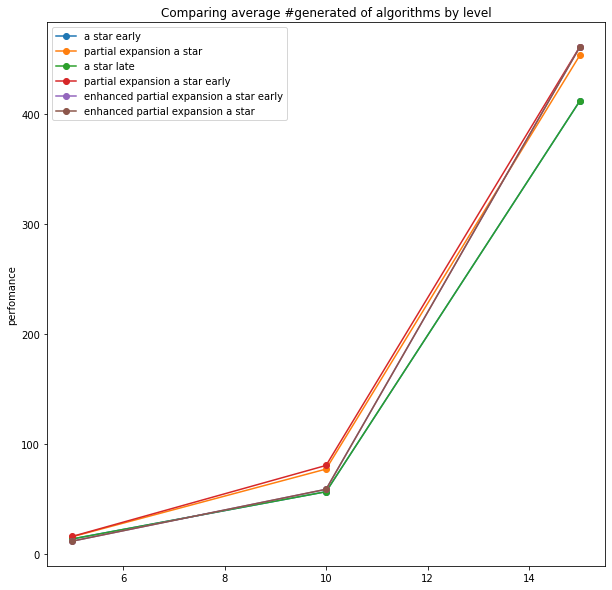

a star early
partial expansion a star
a star late
partial expansion a star early
enhanced partial expansion a star early
enhanced partial expansion a star


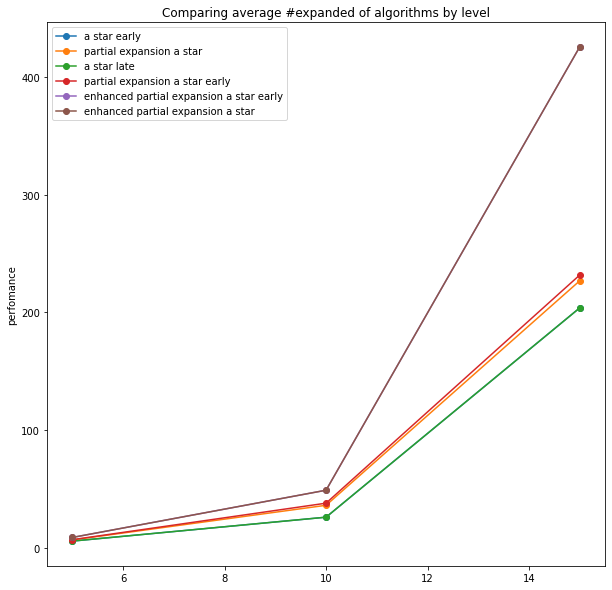

a star early
partial expansion a star
a star late
partial expansion a star early
enhanced partial expansion a star early
enhanced partial expansion a star


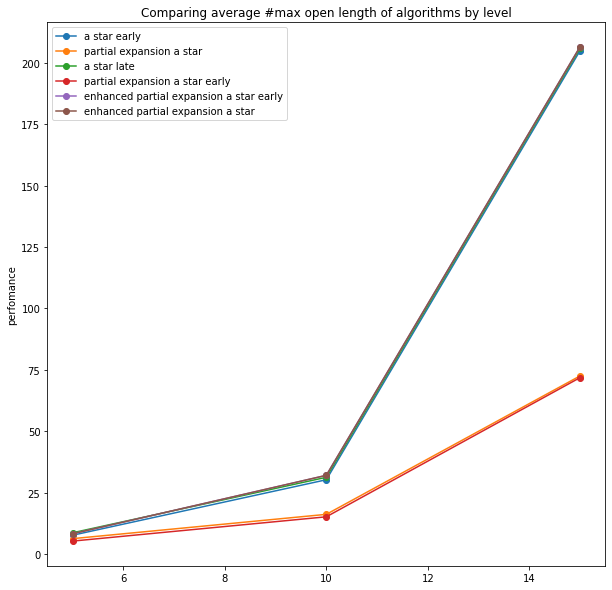

a star early
partial expansion a star
a star late
partial expansion a star early
enhanced partial expansion a star early
enhanced partial expansion a star


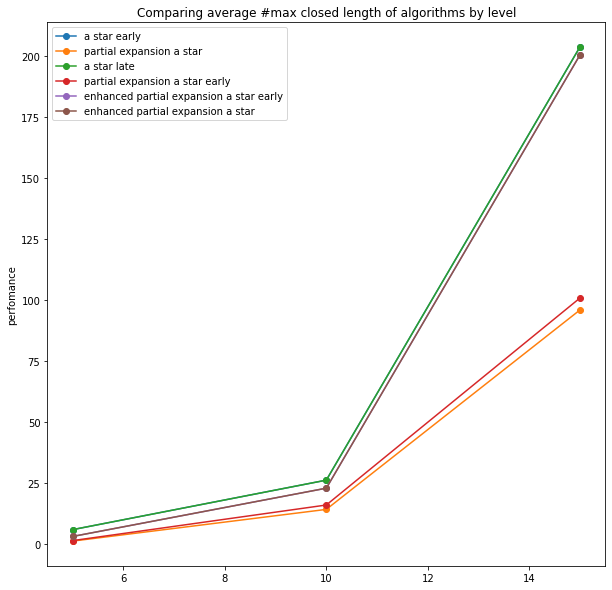

a star early
partial expansion a star
a star late
partial expansion a star early
enhanced partial expansion a star early
enhanced partial expansion a star


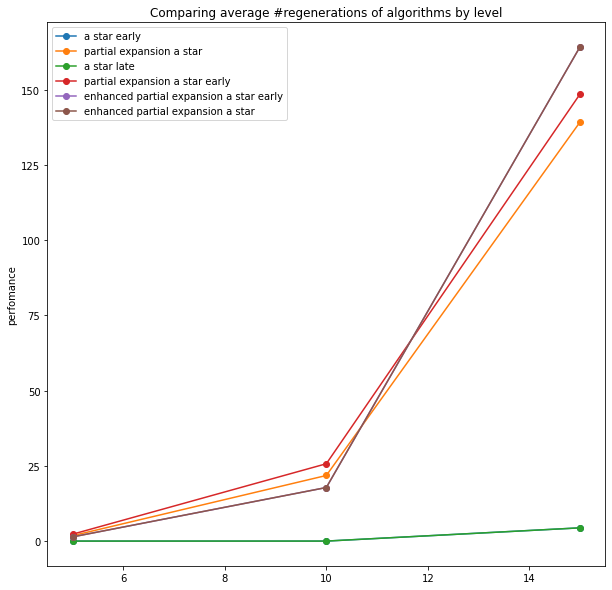

a star early
partial expansion a star
a star late
partial expansion a star early
enhanced partial expansion a star early
enhanced partial expansion a star


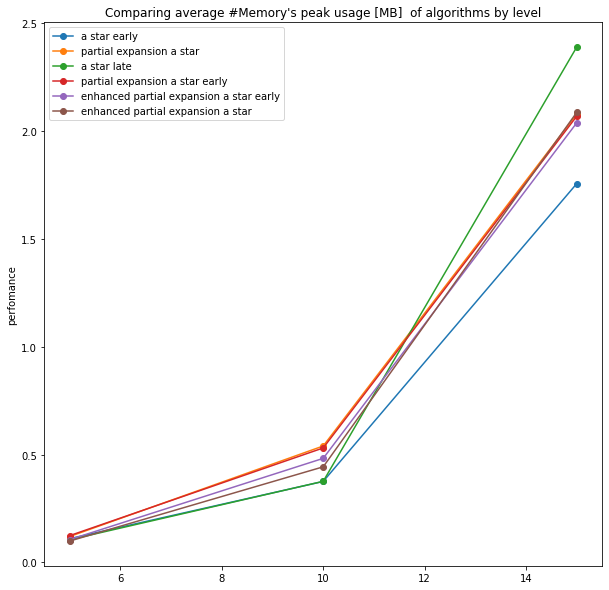

a star early
partial expansion a star
a star late
partial expansion a star early
enhanced partial expansion a star early
enhanced partial expansion a star


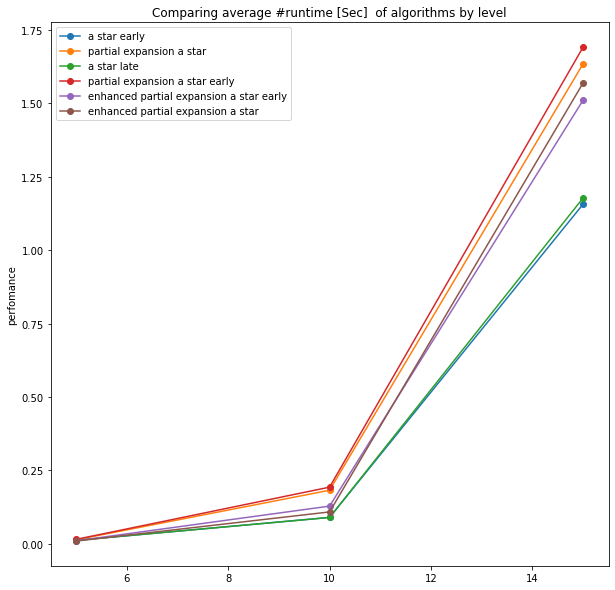

In [ ]:
import matplotlib.pyplot as plt

algorithmns = set([algo for (difficulcy,algo) in avg_perfomance_by_difficulcy_df.index])
difficulcies = ['easy- 5 steps','medium- 10 steps','hard- 15 steps']

for parameter in avg_perfomance_by_difficulcy_df.columns:
  plt.figure(figsize=(10,10))
  for algorithmn in algorithmns:
    print(algorithmn)
    algo_perfomance_by_specific_param = list()
    for difficulcy in difficulcies:
      algo_perfomance_by_specific_param.append(avg_perfomance_by_difficulcy_df.loc[difficulcy].loc[algorithmn][parameter])
    plt.plot([5,10,15],algo_perfomance_by_specific_param,marker='o')
  
  plt.legend(algorithmns)
  plt.title("Comparing average #{} of algorithms by level".format(parameter))
  plt.ylabel('perfomance')
  plt.show()
  plt.close()

    